Outlier_Filter

In [1]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_capability, plot_simple_limits
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
auto_position = widgets.Checkbox(value=False, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

Database *input.db* found in: c:\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
##Database access
table_list = consult_database("input.db", verbose=False)
file = re.sub(r'\W', '_', glob.tooling)
try:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits_corrected_")[-1]
except:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits")[-1]
tables = widgets.SelectMultiple(options=table_list, value=(default_measurements, default_limits), description='input db', rows=10, layout={'width': '600px'})

In [6]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "Measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "Limits" in string), None))
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(0, 1, 2), layout=Layout(width='600px'), options=('PASSAT_B9_Fixt…

Table *PASSAT_B9_Measurements_2024y_08m_21d_10h_36m_41s* retrieved succesfully.
Table *PASSAT_B9_Limits_2024y_08m_21d_10h_36m_41s* retrieved succesfully.


RyR calculation

In [7]:
##RyR dataframe generation
RyR_df = RyR(pd.concat([MEAS, LIMITS], axis=1))
RyR_df_format = rename_index(RyR_df)
print("RyR")
RyR_df_format

RyR


,RyR,Status
Guia_Luz_Blanco_FB1_X,121.668402,High fail
Guia_Luz_Blanco_FB1_Y,29.460157,High fail
Guia_Luz_Blanco_FB2_X,27.279179,High fail
Guia_Luz_Blanco_FB2_Y,6.492208,Correct
Guia_Luz_Blanco_FB3_X,23.701266,Low fail
Guia_Luz_Blanco_FB3_Y,13.067915,Low fail
Guia_Luz_Blanco_FB4_X,94.099896,High fail
Guia_Luz_Blanco_FB4_Y,16.337353,Low fail
Guia_Luz_Blanco_FB5_X,13.948247,Low fail
Guia_Luz_Blanco_FB5_Y,3.015113,Correct


Distribution Fitting

Z-score filtering of outliers

![title](../media/Z-score.jpg)

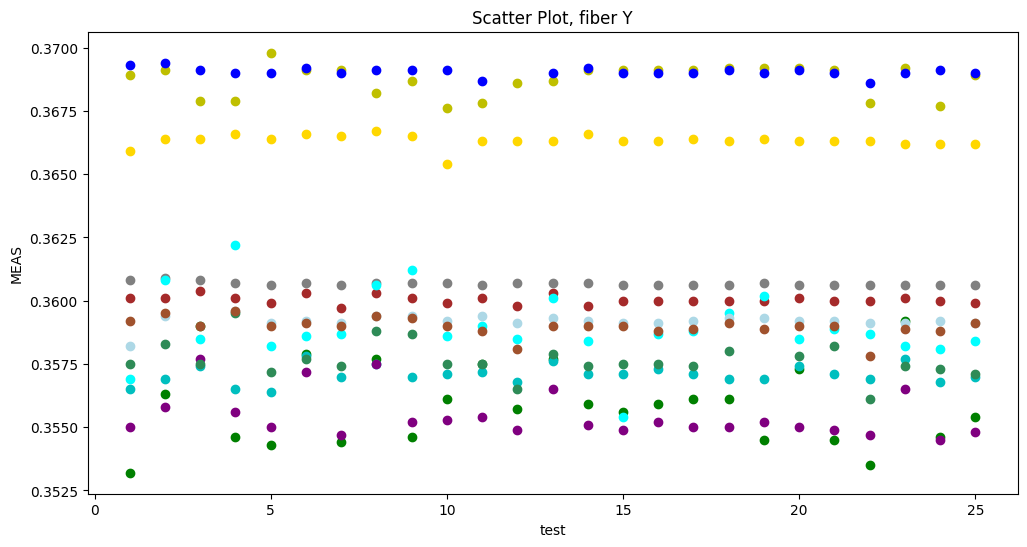

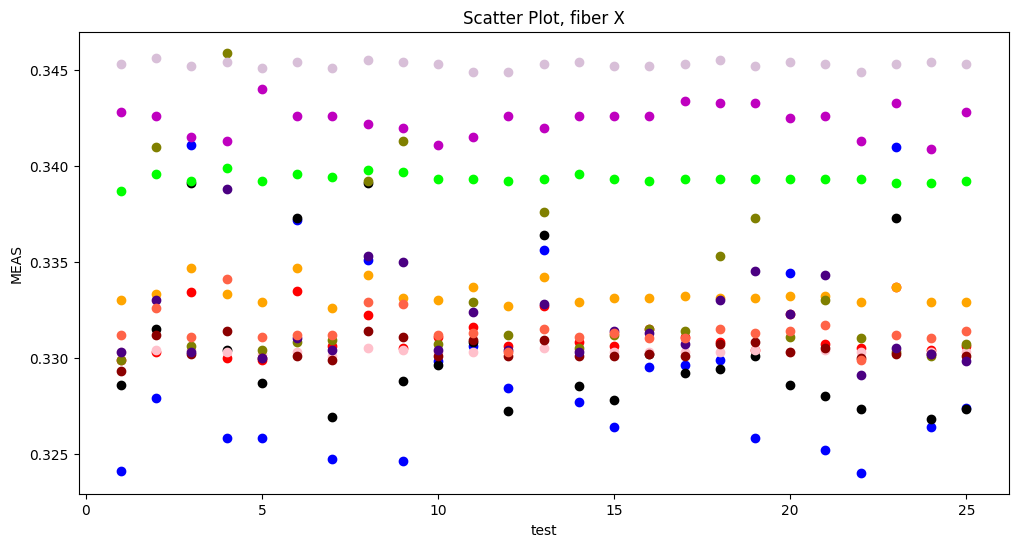

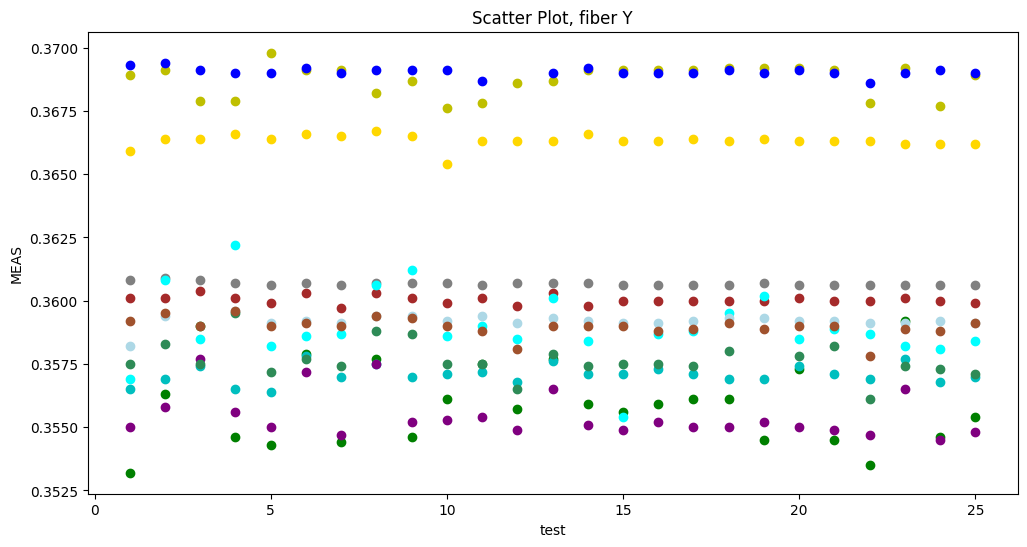

In [11]:
##Filtered data visualization
z_df = z_score_filter(pd.concat([MEAS, LIMITS], axis=1), 1000) #Huge numbers to disable
plot_scatter(z_df.iloc[:, :-2], 'Scatter Plot, fiber X', 'test', 'MEAS', filter='x')
plot_scatter(z_df.iloc[:, :-2], 'Scatter Plot, fiber Y', 'test', 'MEAS', filter='y')

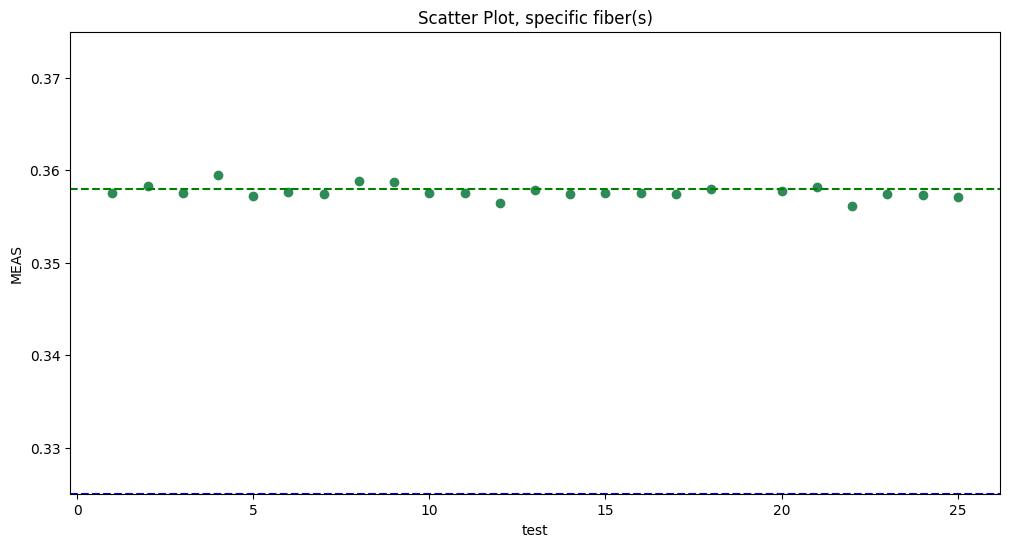

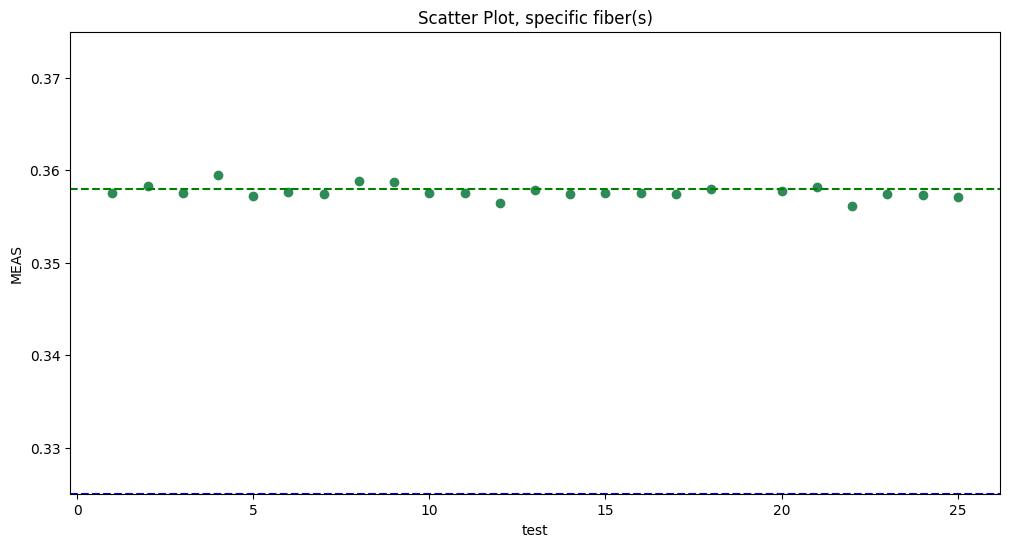

In [13]:
##Specific fibers visualization
if auto_position.value is False:
    range_mapping = [0.05 - 0.005 * (range_slider.value)]
    yrange = [mean_slider.value - range_mapping[0], mean_slider.value + range_mapping[0]]
else:
    range_mapping = None; yrange = None
display(HBox([auto_position, mean_slider, range_slider]))
plot_scatter(MEAS, title='Scatter Plot, specific fiber(s)', xlabel='test', ylabel='MEAS', limits=LIMITS, filter=20, yrange=yrange)

In [14]:
##Filtered data review
z_df_format = rename_index(z_df)
z_df_format.columns = [f"Test: {i}" for i in range(1, z_df_format.shape[1]-1)] + ["LSL", "USL"]
z_df_format

,Test: 1,Test: 2,Test: 3,Test: 4,Test: 5,Test: 6,Test: 7,Test: 8,Test: 9,Test: 10,...,Test: 18,Test: 19,Test: 20,Test: 21,Test: 22,Test: 23,Test: 24,Test: 25,LSL,USL
Guia_Luz_Blanco_FB1_X,0.3241,0.3279,0.3411,0.3258,0.3258,0.3372,0.3247,0.3351,0.3246,0.3298,...,0.3299,0.3258,0.3344,0.3252,0.3240,0.3410,0.3264,0.3274,0.310,0.335
Guia_Luz_Blanco_FB1_Y,0.3532,0.3563,0.3590,0.3546,0.3543,0.3579,0.3544,0.3577,0.3546,0.3561,...,0.3561,0.3545,0.3573,0.3545,0.3535,0.3592,0.3546,0.3554,0.325,0.358
Guia_Luz_Blanco_FB2_X,0.3299,0.3303,0.3334,0.3300,0.3299,0.3335,0.3306,0.3322,0.3305,0.3311,...,0.3308,0.3304,0.3323,0.3307,0.3305,0.3337,0.3304,0.3306,0.310,0.335
Guia_Luz_Blanco_FB2_Y,0.3565,0.3569,0.3574,0.3565,0.3564,0.3578,0.3570,0.3575,0.3570,0.3571,...,0.3569,0.3569,0.3574,0.3571,0.3569,0.3577,0.3568,0.3570,0.325,0.358
Guia_Luz_Blanco_FB3_X,0.3428,0.3426,0.3415,0.3413,0.3440,0.3426,0.3426,0.3422,0.3420,0.3411,...,0.3433,0.3433,0.3425,0.3426,0.3413,0.3433,0.3409,0.3428,0.325,0.345
Guia_Luz_Blanco_FB3_Y,0.3689,0.3691,0.3679,0.3679,0.3698,0.3691,0.3691,0.3682,0.3687,0.3676,...,0.3692,0.3692,0.3692,0.3691,0.3678,0.3692,0.3677,0.3689,0.340,0.368
Guia_Luz_Blanco_FB4_X,0.3286,0.3315,0.3391,0.3304,0.3287,0.3373,0.3269,0.3391,0.3288,0.3296,...,0.3294,0.3301,0.3286,0.3280,0.3273,0.3373,0.3268,0.3273,0.310,0.335
Guia_Luz_Blanco_FB4_Y,0.3550,0.3558,0.3577,0.3556,0.3550,0.3572,0.3547,0.3575,0.3552,0.3553,...,0.3550,0.3552,0.3550,0.3549,0.3547,0.3565,0.3545,0.3548,0.325,0.358
Guia_Luz_Blanco_FB5_X,0.3330,0.3333,0.3347,0.3333,0.3329,0.3347,0.3326,0.3343,0.3331,0.3330,...,0.3331,0.3331,0.3332,0.3332,0.3329,0.3337,0.3329,0.3329,0.310,0.335
Guia_Luz_Blanco_FB5_Y,0.3601,0.3601,0.3604,0.3601,0.3599,0.3603,0.3597,0.3603,0.3601,0.3599,...,0.3600,0.3600,0.3601,0.3600,0.3600,0.3601,0.3600,0.3599,0.325,0.358


In [15]:
##Filtered RyR generation
RyR_df = RyR(z_df)
RyR_df_format = rename_index(RyR_df)
print("RyR filtered")
RyR_df_format

RyR filtered


,RyR,Status
Guia_Luz_Blanco_FB1_X,121.668402,High fail
Guia_Luz_Blanco_FB1_Y,29.460157,High fail
Guia_Luz_Blanco_FB2_X,27.279179,High fail
Guia_Luz_Blanco_FB2_Y,6.492208,Correct
Guia_Luz_Blanco_FB3_X,23.701266,Low fail
Guia_Luz_Blanco_FB3_Y,13.067915,Low fail
Guia_Luz_Blanco_FB4_X,94.099896,High fail
Guia_Luz_Blanco_FB4_Y,16.337353,Low fail
Guia_Luz_Blanco_FB5_X,13.948247,Low fail
Guia_Luz_Blanco_FB5_Y,3.015113,Correct


In [17]:
##Update of the database
name = re.sub(r'\W', '_', glob.tooling + "_" + get_date()) + "_Measurements&filtered"
confirmation = input("Do you want to export the new limits to your database (y/n): ").strip().lower()
if confirmation == 'y':
    prepare_database("input.db", z_df.iloc[:, :-2], name) #Store a df for the limits inside the database of the project
    limits_file = rename_limits_table("output.db", name)
    print("Limit files renamed for clarity.")
    consult_database("input.db", verbose=True)
else:
    print("Operation canceled.")

Dataframe stored as *PASSAT_B9_2024y_08m_21d_11h_31m_14s_Measurements_filtered*
Limit files renamed for clarity.
*input.db* actual contents:
    PASSAT_B9_FixtureData_2024y_08m_21d_10h_53m_25s
    PASSAT_B9_Limits_2024y_08m_21d_10h_36m_41s
    PASSAT_B9_Measurements_2024y_08m_21d_10h_36m_41s
    PASSAT_B9_Measurements_filtered_2024y_08m_21d_11h_31m_14s
    PASSAT_B9_measurements_filtered_2024y_08m_21d_11h_30m_18s
